group testing: 0.0007579229999805648
97
50
Epoch 0 - Training loss: 2.2998671531677246
Epoch 0 - Test loss: 2.294635534286499
Epoch 1 - Training loss: 2.280200958251953
Epoch 1 - Test loss: 2.2609472274780273
Epoch 2 - Training loss: 2.230546236038208
Epoch 2 - Test loss: 2.191711664199829
Epoch 3 - Training loss: 2.216655969619751
Epoch 3 - Test loss: 2.1887521743774414
Epoch 4 - Training loss: 2.144242525100708
Epoch 4 - Test loss: 2.095860719680786
Epoch 5 - Training loss: 2.044513702392578
Epoch 5 - Test loss: 1.9884750843048096
Epoch 6 - Training loss: 1.9377011060714722
Epoch 6 - Test loss: 1.879703402519226
Epoch 7 - Training loss: 1.8427734375
Epoch 7 - Test loss: 1.7982369661331177
Epoch 8 - Training loss: 1.6874648332595825
Epoch 8 - Test loss: 1.6179418563842773
Epoch 9 - Training loss: 1.7063624858856201
Epoch 9 - Test loss: 1.6642764806747437
Epoch 10 - Training loss: 1.6448681354522705
Epoch 10 - Test loss: 1.623583197593689
Epoch 11 - Training loss: 1.4797635078430176
Ep

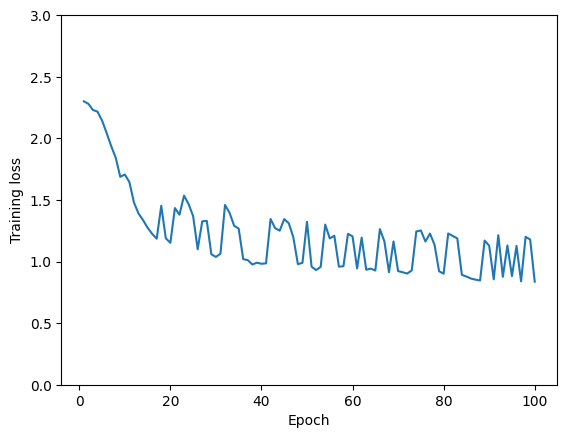

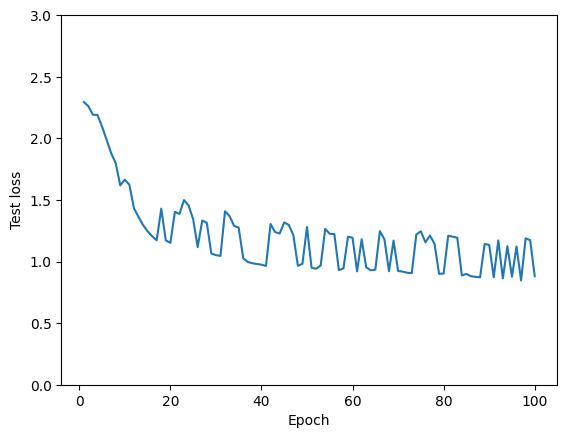

Epoch 100 - Training loss: 0.8200861215591431
Epoch 100 - Test loss: 0.8749716281890869
Epoch 101 - Training loss: 1.1129645109176636
Epoch 101 - Test loss: 1.111465573310852
Epoch 102 - Training loss: 1.1014842987060547
Epoch 102 - Test loss: 1.1102999448776245
Epoch 103 - Training loss: 1.0808287858963013
Epoch 103 - Test loss: 1.1189603805541992
Epoch 104 - Training loss: 1.1972978115081787
Epoch 104 - Test loss: 1.1568397283554077
Epoch 105 - Training loss: 0.8496082425117493
Epoch 105 - Test loss: 0.8558765649795532
Epoch 106 - Training loss: 0.8293728232383728
Epoch 106 - Test loss: 0.8499661087989807
Epoch 107 - Training loss: 0.8219775557518005
Epoch 107 - Test loss: 0.845689058303833
Epoch 108 - Training loss: 0.8315756320953369
Epoch 108 - Test loss: 0.8688926100730896
Epoch 109 - Training loss: 0.8145755529403687
Epoch 109 - Test loss: 0.8641945123672485
Epoch 110 - Training loss: 1.107761263847351
Epoch 110 - Test loss: 1.1023762226104736
Epoch 111 - Training loss: 0.847665

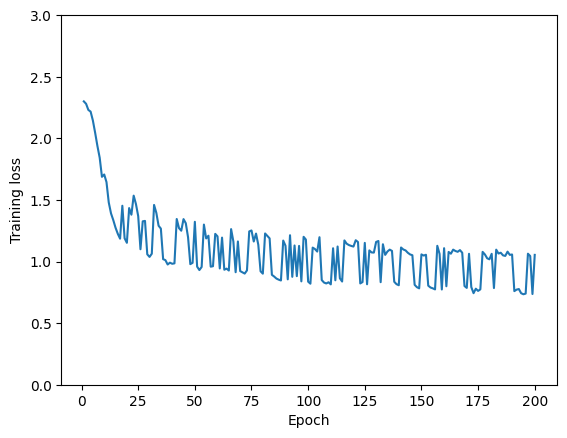

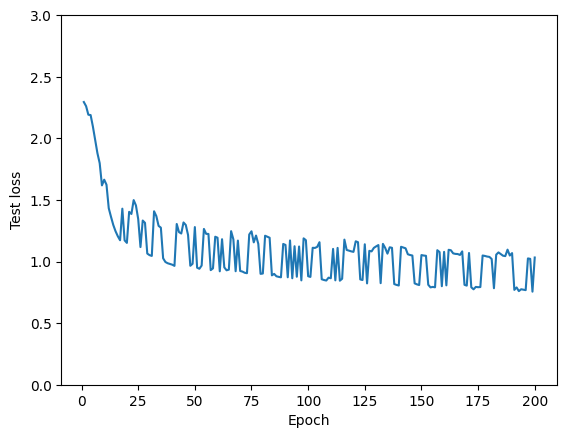

Epoch 200 - Training loss: 1.033005714416504
Epoch 200 - Test loss: 1.0266435146331787
Epoch 201 - Training loss: 1.024266242980957
Epoch 201 - Test loss: 1.044055700302124
Epoch 202 - Training loss: 0.7602230310440063
Epoch 202 - Test loss: 0.773865282535553
Epoch 203 - Training loss: 1.0261768102645874
Epoch 203 - Test loss: 1.0465426445007324
Epoch 204 - Training loss: 1.0299108028411865
Epoch 204 - Test loss: 1.0396796464920044
Epoch 205 - Training loss: 1.0220377445220947
Epoch 205 - Test loss: 1.0388938188552856
Epoch 206 - Training loss: 0.7629344463348389
Epoch 206 - Test loss: 0.757773220539093
Epoch 207 - Training loss: 1.0284948348999023
Epoch 207 - Test loss: 1.0550228357315063
Epoch 208 - Training loss: 1.0511702299118042
Epoch 208 - Test loss: 1.0045275688171387
Epoch 209 - Training loss: 0.7569530010223389
Epoch 209 - Test loss: 0.7665018439292908
Epoch 210 - Training loss: 1.0577285289764404
Epoch 210 - Test loss: 1.0371806621551514
Epoch 211 - Training loss: 1.01525437

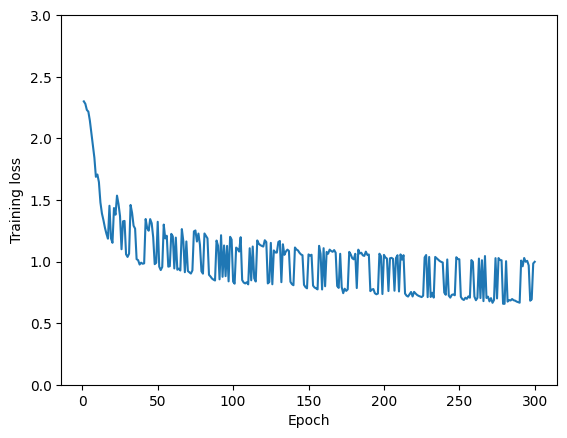

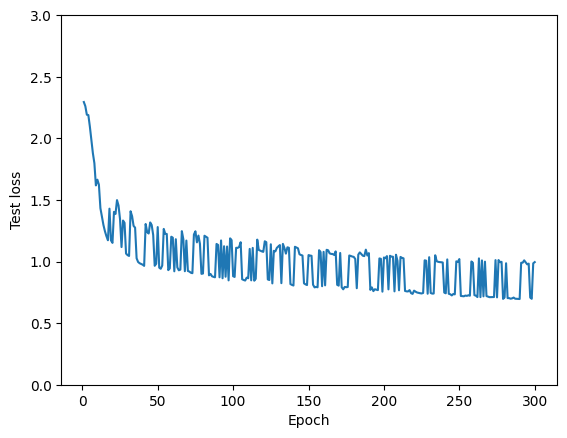

In [2]:
EPOCHS = 300
SUBSET_UPDATE_PROB = 0.8
PADDING_METHOD = "latest"
LEARNING_RATE = 0.1
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [16, 32], "client_2":[16, 32], "client_3": [16, 32], "client_4":[16, 32], "server":[128, 64]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=3, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
s = process_time()
splitNN.group_testing(GROUP_TESTING_ROUNDS)

print('group testing: ' + str(process_time() - s))
test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    s = process_time()
    if (i > 0) and (i % 100 == 0):
        plt.plot(range(1, i+1), performance)
        plt.ylabel('Training loss')
        plt.xlabel('Epoch')
        plt.ylim([0,3])
        plt.show()

        plt.plot(range(1, i+1), test_perf)
        plt.ylabel('Test loss')
        plt.xlabel('Epoch')
        plt.ylim([0,3])
        plt.show()
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
        splitNN.group_testing(GROUP_TESTING_ROUNDS)
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))

res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,3])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,3])
plt.show()

